In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import re, itertools
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from actionability import y_summary, reshape_helper
from IPython.display import Image
import gensim, logging
from gensim.models import Word2Vec

## The training data

We grouped the ratings from the original data set by URL (equivalently, by unit ID):

In [2]:
raw_action_df = pd.read_csv('../data/actionability_rendered.csv', index_col='_unit_id', encoding='utf-8')

In [3]:
print raw_action_df.iloc[0]

action                                                   ListenAction
action_inst         ListenAction: Does the web page offer you the ...
actionrating                                                       13
rating_count                                                       15
action_pct                                                  0.8666667
domain                                                       rdio.com
site                http://www.rdio.com/browse/?ppKey=stations&ppS...
text                <!DOCTYPE html>\n<html>\n  <head>\n    \n    \...
rendered            <!DOCTYPE html><html><head><script src="//d37g...
rendering_failed                                                False
Name: 716816295, dtype: object


The column <code>text</code> is the HTML source of the webpage as obtained with the library <code>requests</code>.

The column <code>rendered</code> is the HTML that resulted from executing the JavaScript on the page using <code>selenium</code> and <code>PhantomJS</code>. If this failed, we fell back on the original HTML source:


The column <code>actionrating</code> gives the number of "Yes" ratings for that URL, and <code>rating_count</code> is the total number of ratings. We take the ratio of these and call it <code>action_pct</code>. Ideally this figure should be 1 or 0, indicating that all users agreed on the (non)actionability of the page; a value of <code>action_pct</code> near 0.5 indicates a lack of consensus on that item. We therefore exclude those webpages whose <code>action_pct</code> is within 0.1 of 0.5.

In [4]:
action_df = raw_action_df[raw_action_df.action_pct.apply(lambda x:abs(x-0.5)) > 0.1].copy()

This leaves us with about 80% of the original data:

In [5]:
len(action_df)*1.0/len(raw_action_df)

0.7984496124031008

For classification purposes, we'll say that a webpage is *actionable* if it has <code>action_pct > 0.5</code>:

In [6]:
action_df['is_actionable'] = (action_df.action_pct > 0.5)

## Feature extraction

From each rendered HTML document, we extract all "words" (maximal alphabetical substrings) from it. We also separately extract those words that are immediately followed by "button", to account for the fact that some button-like HTML elements have names like "PlayButton". Next, we remove a number of stop words (as found in <code>stopwords.txt</code>) and vectorize each document using a <a href="https://code.google.com/p/word2vec/">pretrained Word2Vec model</a>.

In [7]:
action_df['button_types'] = action_df.rendered.apply(lambda x: ' '.join(re.findall(r'(\w+)[Bb]utton',x)).lower())
action_df['tokens'] = action_df.rendered.apply(lambda x: ' '.join(re.findall(r'\w+',x)).lower()) + action_df.button_types

In [8]:
gnews_model = Word2Vec.load_word2vec_format('../data/GoogleNews-vectors-negative300.bin', binary=True)

In [9]:
with open('stopwords.txt') as f:
    stop_words = set(f.read().split(' '))

def clean(s):
    tokens = s.split(' ')
    tokens = [t for t in tokens if (t in gnews_model.vocab) and (t not in stop_words)]
    return ' '.join(tokens)
    
def clean_and_vectorize(s):
    tokens = s.split(' ')
    tokens = [t for t in tokens if (t in gnews_model.vocab) and (t not in stop_words)]
    v = sum([gnews_model[t] for t in tokens])
    if type(v)==int:
        return np.zeros(300)
    return v

In [10]:
action_df['vector'] = action_df.tokens.apply(clean_and_vectorize)

## Building the classifier and cross-validating

To use these features to predict actionability, we employ $\ell^2$-regularized logistic regression. We construct one classifier for each type of action, as we expect that each action should be associated with its own set of relevant words.

In [11]:
clf = LogisticRegression(C=0.6, penalty='l2')

For each action, we cross-validate by setting aside one domain at a time as a test set:

In [12]:
def cvd(X, y, labels, clfs):
    """
    Perform leave-one-label-out cross-validation, converting strings to bag-of-words vectors.
    Return a DataFrame summarizing the results.
    """
    all_y_test = np.array([])
    all_y_pred = np.array([])
    results = []
    for clf in clfs:
        labels = np.array(labels)

        for label in np.unique(labels):       
            #print label
            # set aside everything with given label as test set
            train_index = (labels != label)
            test_index = (labels == label)

            X_train, X_test = reshape_helper(X[train_index]), reshape_helper(X[test_index])
            y_train, y_test = y[train_index], y[test_index]
            
            clf.fit(X_train, y_train)

            y_pred = clf.predict(X_test)
            precision, recall, fbeta, support = precision_recall_fscore_support(y_test, y_pred, average='binary')
            accuracy = sum(y_pred == y_test)*1.0/len(y_test)
            true_proportion = sum(y_test)*1.0/len(y_test)
            predicted_proportion = sum(y_pred)*1.0/len(y_pred)
            auc = roc_auc_score(y_test, y_pred)
            results += [(label, len(y_test), accuracy, precision, recall, true_proportion, predicted_proportion, auc)]
            all_y_test = np.append(all_y_test, y_test)
            all_y_pred = np.append(all_y_pred, y_pred)
    result_df = pd.DataFrame(results)
    result_df.columns = ['domain','page_count','accuracy','precision','recall', 'true_proportion', 'predicted_proportion', 'auc']
    return result_df, all_y_test, all_y_pred

In [13]:
cvdfs = []
summaries = []

for action in np.unique(action_df.action):
    df = action_df[action_df.action==action]
    
    X = df.vector.values
    y = df.is_actionable.values
    labels = df.domain.values

    cvdf, all_y_test, all_y_pred = cvd(X, y, labels, [clf])
    cvdf['action'] = action
    cvdfs += [cvdf]
    
    precision, recall, accuracy, true_proportion, predicted_proportion, auc = y_summary(all_y_test, all_y_pred)
    summaries += [{'action':action, 'precision':precision, 
                  'recall':recall, 'accuracy':accuracy, 
                  'true_proportion':true_proportion, 'predicted_proportion':predicted_proportion, 'auc':auc}]
cvdf = pd.concat(cvdfs)
cvdf.set_index('domain',inplace=True)
del cvdfs

/home/bradhd/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:958: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


## Classifier performance

First, the overall results obtained by combining each out-of-sample prediction:

In [14]:
pd.DataFrame(summaries).set_index('action')

,accuracy,auc,precision,predicted_proportion,recall,true_proportion
action,,,,,,
ListenAction,0.536946,0.663308,0.933333,0.369458,0.440252,0.783251
TicketsAction,0.732372,0.742193,0.834921,0.504808,0.695767,0.605769


The column <code>predicted_proportion</code> is the total proportion of webpages predicted to be actionable; <code>true_proportion</code> is the true proportion, independent of the classifier.

Let's take a closer look. Here are the results on each domain as a test set:

In [15]:
cvdf.sort(['action','accuracy'])

,page_count,accuracy,precision,recall,true_proportion,predicted_proportion,auc,action
domain,,,,,,,,
spotify.com,84,0.297619,0.000000,0.000000,0.702381,0.000000,0.500000,ListenAction
rhapsody.com,89,0.303371,1.000000,0.126761,0.797753,0.101124,0.563380,ListenAction
soundcloud.com,93,0.559140,0.961538,0.561798,0.956989,0.559140,0.530899,ListenAction
pandora.com,49,0.591837,0.777778,0.280000,0.510204,0.183673,0.598333,ListenAction
rdio.com,91,0.934066,0.925000,1.000000,0.813187,0.879121,0.823529,ListenAction
songkick.com,79,0.481013,1.000000,0.023810,0.531646,0.012658,0.511905,TicketsAction
thrillcall.com,91,0.593407,0.782609,0.360000,0.549451,0.252747,0.619024,TicketsAction
razorgator.com,85,0.670588,0.950000,0.695122,0.964706,0.705882,0.347561,TicketsAction
livenation.com,62,0.693548,0.650000,0.838710,0.500000,0.645161,0.693548,TicketsAction


## Analysis

Let's visualize the precision and accuracy on each domain.

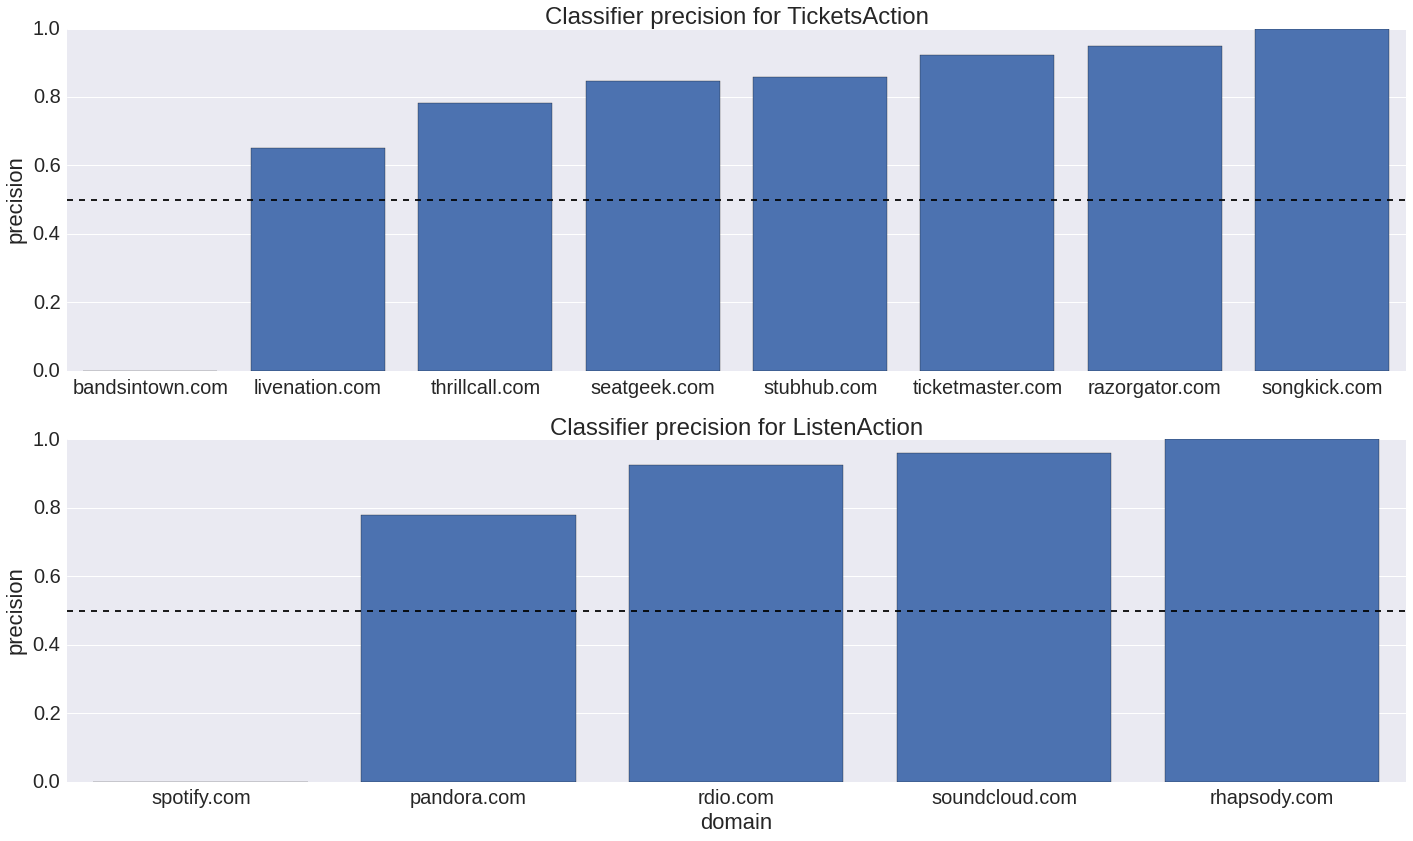

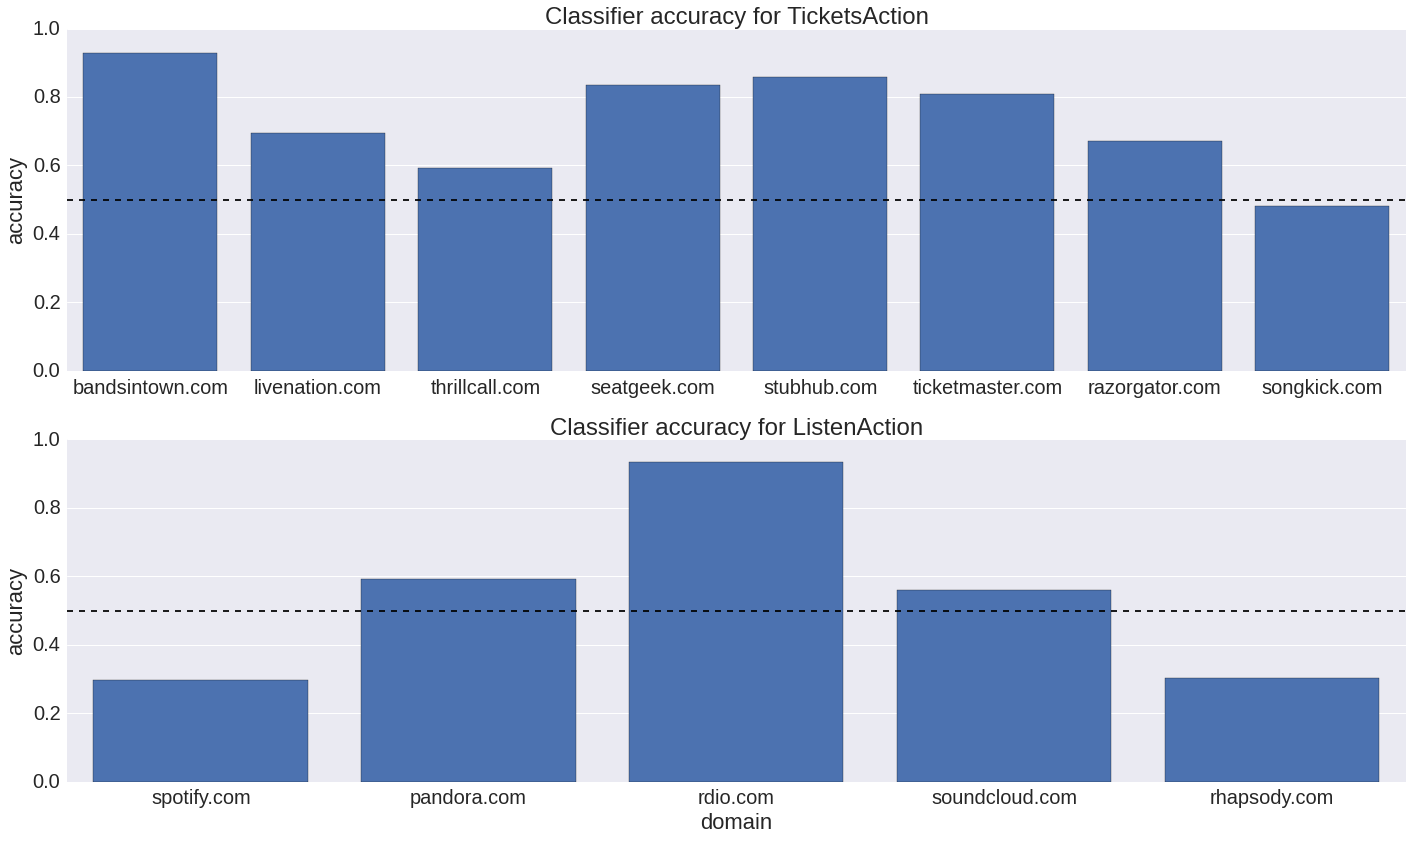

In [16]:
%matplotlib inline

for c in ['precision', 'accuracy']:
    sns.set(font_scale=2)
    plt.rcParams['font.size'] = 36

    fig = plt.figure()
    fig.set_size_inches(1920/fig.dpi, 1080/fig.dpi)
    nrows, ncols = 2,1

    tdf = cvdf[cvdf.action=='TicketsAction']
    ax=fig.add_subplot(nrows, ncols, 1)
    sns.barplot(tdf.index, tdf[c], x_order=tdf.sort('precision').index)
    plt.axhline(y=0.5, color='k', ls='dashed')
    plt.title('Classifier %s for TicketsAction' % c)
    plt.xlabel('')

    tdf = cvdf[cvdf.action=='ListenAction']
    ax=fig.add_subplot(nrows, ncols, 2)
    sns.barplot(tdf.index, tdf[c], x_order=tdf.sort('precision').index)
    plt.axhline(y=0.5, color='k', ls='dashed')
    plt.title('Classifier %s for ListenAction' % c)

In interpreting the precision, it's important to take the accuracy and predicted proportion into consideration. For example, while the precision for each of rhapsody.com and songkick.com is 100%, we can see from the predicted proportions that for each of these domains, only one webpage was classified as actionable. The precision of 100% reflects the fact that this one webpage was indeed actionable, according to CrowdFlower.

Conversely, while the classifier had 0% precision on bandsintown.com, only one of the webpages on that domain was considered actionable by CrowdFlower users -- the classifier was about 93% accurate.

We can also see that the learner does overall quite poorly on spotify.com, going by either precision or accuracy. In fact, the learner classified *every* page on spotify.com as non-actionable, despite the CrowdFlower-reported actionability rate of 70%. What does an actionable page from Spotify look like?

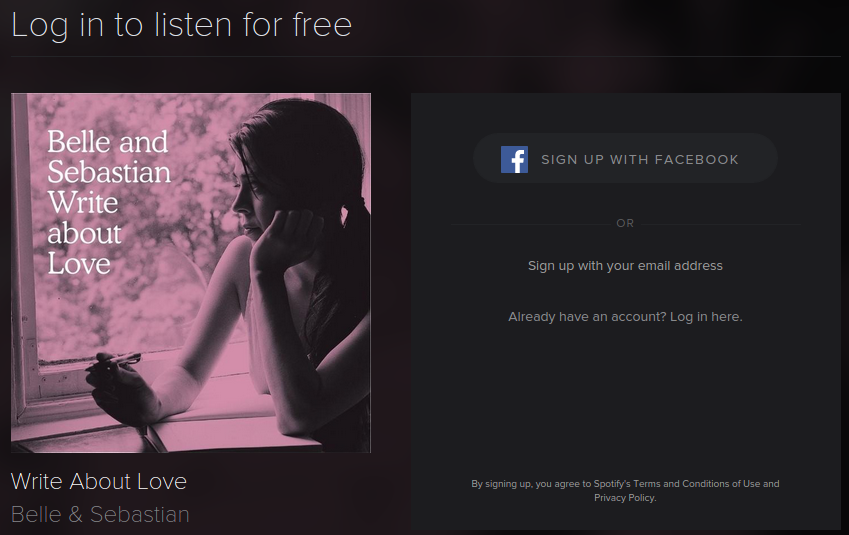

In [17]:
Image('spotify.png', width=600)

It seems that the reader needs to be logged in to Spotify in order to be presented with the option to listen to music. The headless browser we used to open the pages did not have any such credentials, so it's unsurprising that it classified these pages as non-actionable.

## Future directions

In building the classifier, the original approach I took was to parse the HTML using <code>lxml</code> and extract only the tokens that appeared in the text of links and buttons. However, it proved to be a fruitless task to try to account for the countless ways in which these clickable elements can be constructed in HTML. The "shotgun" approach used above, where we extract *all* of the alphabetical tokens, ended up being both simpler and more effective. But it would be interesting to see if a more sophisticated targeted approach could make for a more accurate classifier. 

One idea I had in this direction is to simulate the user experience by rendering the webpage as an image, which can be done with <code>selenium</code> or another headless browser, and apply computer-vision algorithms (as implemented in <a href="http://opencv.org/">OpenCV</a>, for example) to detect button-like features of the image and extract the text and symbols like &#9654; found within or near those elements. These features could then be fed into Word2Vec or another token vectorization scheme.